# Challenge: The Boston marathon

There is a lot of information on runners and their performance for the Boston Marathon. Pick a year (post-2012 has more info) and do some clustering.

Specifically, use the tools at hand to determine which clustering solution, including number of clusters and algorithm used, is best for the marathon data. Once you have a solution you like, write a data story, including visualizations, where you teach the reader something about the Boston Marathon based on your clusters. Write up your report, including your process from start to finish, in a Jupyter notebook and submit it below.

https://github.com/llimllib/bostonmarathon

https://github.com/llimllib/bostomarathon/blob/master/results/2014/results.csv

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
from itertools import cycle

%matplotlib inline

In [2]:
df = pd.read_csv(r'C:\Users\katec\Thinkful\data_collections/boston_marathon.csv', error_bad_lines=False)    

In [3]:
pd.set_option('display.max_columns', 50)

In [4]:
df.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,35k,overall,pace,state,30k,5k,half,20k,country,city,40k
0,17.37,"Yamamoto, Hiroyuki",8,47.67,M,47,85.25,W1,8,NaN,71.4,8,3.27,NaN,59.18,8.02,39.72,37.65,JPN,Fukuoka,80.43
1,32.58,"Jeptoo, Rita",1,82.43,F,33,138.95,F1,1,NaN,116.37,21,5.30,NaN,99.33,16.22,69.47,65.83,KEN,Eldoret,132.1
2,16.62,"Van Dyk, Ernst F.",1,45.8,M,41,80.60,W2,1,NaN,67.42,1,3.08,NaN,56.45,7.75,38.03,36.1,RSA,Paarl,76.1
3,32.57,"Dibaba, Mare",3,82.43,F,24,140.58,F2,3,NaN,116.37,27,5.37,NaN,99.33,16.2,69.47,65.83,ETH,Shoa,132.95
4,17.12,"Hokinoue, Kota",2,46.37,M,40,81.23,W3,2,NaN,67.83,2,3.10,NaN,57.03,8.02,38.6,36.58,JPN,Nogata Fukuoka,76.72


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 21 columns):
10k          31984 non-null object
name         31984 non-null object
division     31984 non-null int64
25k          31984 non-null object
gender       31984 non-null object
age          31984 non-null int64
official     31984 non-null float64
bib          31984 non-null object
genderdiv    31984 non-null int64
ctz          1244 non-null object
35k          31984 non-null object
overall      31984 non-null int64
pace         31984 non-null float64
state        29408 non-null object
30k          31984 non-null object
5k           31984 non-null object
half         31984 non-null object
20k          31984 non-null object
country      31984 non-null object
city         31983 non-null object
40k          31984 non-null object
dtypes: float64(2), int64(4), object(15)
memory usage: 5.1+ MB


In [6]:
#convert to numeric
cols = ['10k', '25k', '35k', '30k', '5k', 'half', '20k', '40k']
df[cols] = df[cols].apply(pd.to_numeric, errors = 'coerce', downcast = 'float')


In [7]:
df.isnull().sum()

10k             50
name             0
division         0
25k            216
gender           0
age              0
official         0
bib              0
genderdiv        0
ctz          30740
35k             34
overall          0
pace             0
state         2576
30k             40
5k              52
half            72
20k             51
country          0
city             1
40k             39
dtype: int64

In [8]:
#drop 'ctz' column, empty
df = df.drop(['ctz'], axis=1)

In [9]:
#fill missimg 'state', 'city' with 'Not available'
fill_list = ['state', 'city']
for column in fill_list:
        df.loc[:, column] = df.loc[:, column].fillna(value= 'Not available') 

Conversion factor
26 miles 385 yards = 42.195 km;  
1 = 1.60934

In [10]:
#convert pace from miles to km (factor = 1.60934)
df['pace_km'] = df['pace']* 1.60934
df.head()

,10k,name,division,25k,gender,age,official,bib,genderdiv,35k,overall,pace,state,30k,5k,half,20k,country,city,40k,pace_km
0,17.370001,"Yamamoto, Hiroyuki",8,47.669998,M,47,85.25,W1,8,71.400002,8,3.27,Not available,59.180000,8.020000,39.720001,37.650002,JPN,Fukuoka,80.430000,5.262542
1,32.580002,"Jeptoo, Rita",1,82.430000,F,33,138.95,F1,1,116.370003,21,5.30,Not available,99.330002,16.219999,69.470001,65.830002,KEN,Eldoret,132.100006,8.529502
2,16.620001,"Van Dyk, Ernst F.",1,45.799999,M,41,80.60,W2,1,67.419998,1,3.08,Not available,56.450001,7.750000,38.029999,36.099998,RSA,Paarl,76.099998,4.956767
3,32.570000,"Dibaba, Mare",3,82.430000,F,24,140.58,F2,3,116.370003,27,5.37,Not available,99.330002,16.200001,69.470001,65.830002,ETH,Shoa,132.949997,8.642156
4,17.120001,"Hokinoue, Kota",2,46.369999,M,40,81.23,W3,2,67.830002,2,3.10,Not available,57.029999,8.020000,38.599998,36.580002,JPN,Nogata Fukuoka,76.720001,4.988954


In [ ]:
df['25k'].describe()

fill for single: 
df['5k'] = df['5k'].fillna(5 * df['pace_km'])

In [11]:
#fill missing marker time values by 
#multiply factor_list by 'pace_km'
fill2_list = ['5k', '10k', '20k', '25k', '30k', '35k', '40k']

for c in fill2_list:
        df[c].fillna(df['pace_km'] * int(c.replace('k', '')), inplace=True) 

In [12]:
df.isnull().sum()

10k           0
name          0
division      0
25k           0
gender        0
age           0
official      0
bib           0
genderdiv     0
35k           0
overall       0
pace          0
state         0
30k           0
5k            0
half         72
20k           0
country       0
city          0
40k           0
pace_km       0
dtype: int64

In [13]:
#fill missing marker time values by 
#dividing 'official' in half
#fill3_list = ['half']

for column in fill_list:
        df['half'] = df['half'].fillna(df['official']/2) 

In [14]:
df.isnull().sum()

10k          0
name         0
division     0
25k          0
gender       0
age          0
official     0
bib          0
genderdiv    0
35k          0
overall      0
pace         0
state        0
30k          0
5k           0
half         0
20k          0
country      0
city         0
40k          0
pace_km      0
dtype: int64

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 21 columns):
10k          31984 non-null float32
name         31984 non-null object
division     31984 non-null int64
25k          31984 non-null float32
gender       31984 non-null object
age          31984 non-null int64
official     31984 non-null float64
bib          31984 non-null object
genderdiv    31984 non-null int64
35k          31984 non-null float32
overall      31984 non-null int64
pace         31984 non-null float64
state        31984 non-null object
30k          31984 non-null float32
5k           31984 non-null float32
half         31984 non-null float32
20k          31984 non-null float32
country      31984 non-null object
city         31984 non-null object
40k          31984 non-null float32
pace_km      31984 non-null float64
dtypes: float32(8), float64(3), int64(4), object(6)
memory usage: 4.1+ MB


In [16]:
continuous_features = ['10k', 'division', '25k', 'age', 'official', 
                       'genderdiv', '35k', 'overall', 'pace', '30k', 
                       '5k', 'half', '20k', '40k', 'pace_km']

In [17]:
df[continuous_features].describe()

,10k,division,25k,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k,pace_km
count,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000
mean,51.980061,1932.563032,136.680176,42.407079,242.997314,8051.044741,197.289169,15939.587825,9.275658,165.036575,25.843662,111.700729,106.134109,229.882507,14.927688
std,10.160045,1715.228694,45.737686,11.316496,52.300431,4754.005626,44.339222,9232.978224,1.992486,36.733776,4.883998,21.084845,22.788675,55.603344,3.206588
min,16.620001,1.000000,45.799999,18.000000,80.600000,1.000000,67.419998,1.000000,3.080000,56.450001,7.750000,38.029999,36.099998,76.099998,4.956767
25%,45.419998,610.000000,115.570000,33.000000,205.527500,3972.000000,167.149994,7943.750000,7.850000,140.694996,22.650000,96.870003,91.769997,193.830002,12.633319
50%,50.349998,1425.000000,129.070007,42.000000,232.370000,7970.000000,188.220001,15939.500000,8.870000,157.779999,25.100000,107.870003,102.180000,218.899994,14.274846
75%,57.200001,2611.000000,148.380005,50.000000,273.235000,11968.000000,220.279999,23935.250000,10.430000,183.080002,28.500000,123.120003,116.599998,257.649994,16.785416
max,261.195892,6979.000000,710.925964,81.000000,538.880000,17575.000000,974.455383,31931.000000,20.570000,853.111145,130.597946,236.669998,568.740784,1137.481567,33.104124


In [18]:
#for column in binary_features:
binary_features = ['gender']
   
for column in binary_features:
    df = pd.concat([df,pd.get_dummies(df[column], prefix=column, drop_first=True)], axis=1)
    df = df.drop(['gender'], axis=1)
    
df.head()

,10k,name,division,25k,age,official,bib,genderdiv,35k,overall,pace,state,30k,5k,half,20k,country,city,40k,pace_km,gender_M
0,17.370001,"Yamamoto, Hiroyuki",8,47.669998,47,85.25,W1,8,71.400002,8,3.27,Not available,59.180000,8.020000,39.720001,37.650002,JPN,Fukuoka,80.430000,5.262542,1
1,32.580002,"Jeptoo, Rita",1,82.430000,33,138.95,F1,1,116.370003,21,5.30,Not available,99.330002,16.219999,69.470001,65.830002,KEN,Eldoret,132.100006,8.529502,0
2,16.620001,"Van Dyk, Ernst F.",1,45.799999,41,80.60,W2,1,67.419998,1,3.08,Not available,56.450001,7.750000,38.029999,36.099998,RSA,Paarl,76.099998,4.956767,1
3,32.570000,"Dibaba, Mare",3,82.430000,24,140.58,F2,3,116.370003,27,5.37,Not available,99.330002,16.200001,69.470001,65.830002,ETH,Shoa,132.949997,8.642156,0
4,17.120001,"Hokinoue, Kota",2,46.369999,40,81.23,W3,2,67.830002,2,3.10,Not available,57.029999,8.020000,38.599998,36.580002,JPN,Nogata Fukuoka,76.720001,4.988954,1


In [19]:
categorical_features = ['name', 'bib', 'state', 'country',
                       'city',]

In [20]:
df[categorical_features].describe()

,name,bib,state,country,city
count,31984,31984,31984,31984,31984
unique,31915,31984,69,78,5935
top,"Lee, Kerry",7359,MA,USA,Boston
freq,2,1,7587,27233,1034


In [21]:
df['gender_M'].describe()

count    31984.000000
mean         0.550807
std          0.497420
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: gender_M, dtype: float64

### explore categorical data to determine best 

In [22]:
df['state'].value_counts()

MA               7587
Not available    2576
CA               2326
NY               1553
ON               1052
PA               1001
TX                992
IL                916
OH                760
FL                750
VA                713
MI                695
NC                618
WA                596
CO                578
NJ                569
MN                556
MD                527
NH                526
CT                521
GA                443
WI                433
UT                431
QC                419
OR                406
AZ                318
IN                291
TN                261
MO                256
ME                250
                 ... 
ID                124
NE                111
NS                109
AL                105
OK                 92
NV                 88
LA                 78
NM                 71
MT                 65
DE                 63
WV                 56
NB                 55
AK                 50
HI                 49
AR        

The second highest frequency is 'Not Available'. Will drop 'state'. 

In [23]:
df['country'].value_counts()

USA    27233
CAN     2175
GBR      346
ITA      212
MEX      205
GER      182
JPN      175
AUS      124
IRL      119
FRA      115
ESP       89
BRA       87
SWE       66
SUI       62
KOR       60
NED       54
HKG       53
DEN       50
CHN       42
COL       40
CHI       29
FIN       28
ISL       28
BEL       27
SIN       23
AUT       22
NOR       21
RSA       19
VEN       19
RUS       18
       ...  
MAS        4
TUR        4
LUX        4
CZE        4
UKR        3
ECU        3
DOM        3
PAN        3
HUN        3
EGY        2
ROU        2
ESA        2
BAH        2
THA        2
QAT        2
BLR        1
TRI        1
INA        1
BOL        1
BAR        1
EST        1
BRN        1
CRO        1
TAN        1
LIE        1
ZIM        1
VGB        1
MAR        1
URU        1
CAY        1
Name: country, Length: 78, dtype: int64

In [24]:
df['city'].value_counts()

Boston              1034
New York             498
Chicago              313
Cambridge            311
Somerville           240
Toronto              240
Brookline            222
Washington           212
Newton               201
San Francisco        192
Austin               192
Portland             191
Arlington            184
San Diego            182
Brighton             151
Seattle              149
Charlestown          148
Houston              138
London               135
Quincy               134
Medford              132
Brooklyn             131
South Boston         130
Ottawa               130
Atlanta              122
Denver               118
Dorchester           117
Calgary              109
Cincinnati           106
Philadelphia         105
                    ... 
Valley Falls           1
Portlan                1
Mebane                 1
Kagawa                 1
Delevan                1
El Macero              1
Aldie                  1
Ste-Julie              1
Lacey                  1


To combine levels using their frequency, we first look at the frequency distribution of of each level and combine levels having frequency less than 1% of total observation (5% is standard but you can change it based on distribution). This is an effective method to deal with rare levels.

In [25]:
cntry_list = df['country']

def hot_code(cntry_list, thresh):
        d = pd.get_dummies(cntry_list)
        f = pd.value_counts(cntry_list, sort=False, normalize=True) < thresh
        if f.sum() == 0:
            return d
        else:
            return d.loc[:, ~f].join(d.loc[:, f].sum(1).rename('other'))

In [26]:
hot_code_df = hot_code(cntry_list, .001)
hot_code_df.head()

,AUS,BRA,CAN,CHN,COL,DEN,ESP,FRA,GBR,GER,HKG,IRL,ITA,JPN,KOR,MEX,NED,SUI,SWE,USA,other
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [27]:
df = pd.concat([df, hot_code_df], axis=1)

In [28]:
df.head()

,10k,name,division,25k,age,official,bib,genderdiv,35k,overall,pace,state,30k,5k,half,20k,country,city,40k,pace_km,gender_M,AUS,BRA,CAN,CHN,COL,DEN,ESP,FRA,GBR,GER,HKG,IRL,ITA,JPN,KOR,MEX,NED,SUI,SWE,USA,other
0,17.370001,"Yamamoto, Hiroyuki",8,47.669998,47,85.25,W1,8,71.400002,8,3.27,Not available,59.180000,8.020000,39.720001,37.650002,JPN,Fukuoka,80.430000,5.262542,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,32.580002,"Jeptoo, Rita",1,82.430000,33,138.95,F1,1,116.370003,21,5.30,Not available,99.330002,16.219999,69.470001,65.830002,KEN,Eldoret,132.100006,8.529502,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,16.620001,"Van Dyk, Ernst F.",1,45.799999,41,80.60,W2,1,67.419998,1,3.08,Not available,56.450001,7.750000,38.029999,36.099998,RSA,Paarl,76.099998,4.956767,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,32.570000,"Dibaba, Mare",3,82.430000,24,140.58,F2,3,116.370003,27,5.37,Not available,99.330002,16.200001,69.470001,65.830002,ETH,Shoa,132.949997,8.642156,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,17.120001,"Hokinoue, Kota",2,46.369999,40,81.23,W3,2,67.830002,2,3.10,Not available,57.029999,8.020000,38.599998,36.580002,JPN,Nogata Fukuoka,76.720001,4.988954,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [29]:
df_boston = df.drop(['name', 'bib', 'state', 'country', 'city'], axis=1)

In [30]:
df_boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31984 entries, 0 to 31983
Data columns (total 37 columns):
10k          31984 non-null float32
division     31984 non-null int64
25k          31984 non-null float32
age          31984 non-null int64
official     31984 non-null float64
genderdiv    31984 non-null int64
35k          31984 non-null float32
overall      31984 non-null int64
pace         31984 non-null float64
30k          31984 non-null float32
5k           31984 non-null float32
half         31984 non-null float32
20k          31984 non-null float32
40k          31984 non-null float32
pace_km      31984 non-null float64
gender_M     31984 non-null uint8
AUS          31984 non-null uint8
BRA          31984 non-null uint8
CAN          31984 non-null uint8
CHN          31984 non-null uint8
COL          31984 non-null uint8
DEN          31984 non-null uint8
ESP          31984 non-null uint8
FRA          31984 non-null uint8
GBR          31984 non-null uint8
GER          31984 

## k-means cluster

### choosing k

In [31]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
mms.fit(df_boston)
df_transfmd = mms.transform(df_boston)

C:\Users\katec\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype uint8, float32, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [32]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df_transfmd)
    Sum_of_squared_distances.append(km.inertia_)

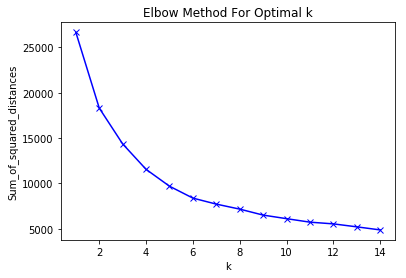

In [33]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

No clear elbow, will choose k=6

In [34]:
# Define the features and the outcome.
X = df_boston.loc[:, df_boston.columns != 'overall']
y = df_boston['overall']


In [40]:
from sklearn.cluster import KMeans
Kmean = KMeans(n_clusters=6, random_state=42)
# Normalize the data.
X_norm = normalize(X)
Kmean.fit(X_norm)

# Calculate predicted values.
y_pred = Kmean.fit_predict(X_norm)

In [41]:
#finding the centroid
Kmean.cluster_centers_

array([[ 4.97763537e-03,  4.07077330e-01,  1.32100160e-02,
         2.82957507e-03,  2.37598620e-02,  9.09882877e-01,
         1.92327742e-02,  9.06886139e-04,  1.60036938e-02,
         2.47654255e-03,  1.07396250e-02,  1.02021391e-02,
         2.24819980e-02,  1.45948814e-03,  4.48335342e-05,
         1.82810167e-07,  1.59820230e-07,  2.78918624e-06,
         1.92101511e-07,  1.01085377e-08,  9.06722935e-08,
         2.07709178e-07,  1.48731589e-07,  8.17683761e-07,
         1.77646454e-07,  7.56089694e-08,  4.63902157e-07,
         1.63137099e-07,  9.53546067e-08,  3.39071879e-08,
         4.37615474e-07,  4.80346035e-08,  1.35438049e-07,
         4.77746354e-08,  8.33401285e-05,  7.72173845e-07],
       [ 1.03362497e-01,  1.93424969e-01,  2.62650139e-01,
         9.71085383e-02,  4.54270411e-01,  2.95269326e-01,
         3.75071829e-01,  1.73493381e-02,  3.18175212e-01,
         5.15016489e-02,  2.20497066e-01,  2.09404469e-01,
         4.29374701e-01,  2.79209838e-02,  1.60714845e-

# what happened here???

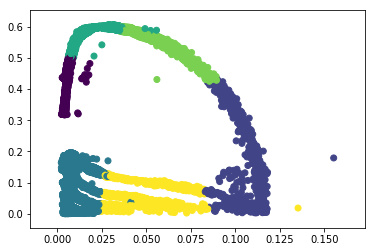

Comparing k-means clusters against the data:
overall  1      2      3      4      5      6      7      8      9      10     \
row_0                                                                           
0            0      0      0      0      0      0      0      0      0      0   
1            2      2      2      2      2      2      2      2      2      2   
2            0      0      0      0      0      0      0      0      0      0   
3            0      0      0      0      0      0      0      0      0      0   
4            0      0      0      0      0      0      0      0      0      0   
5            0      0      0      0      0      0      0      0      0      0   

overall  11     12     13     14     15     16     17     18     19     20     \
row_0                                                                           
0            0      0      0      0      0      0      0      0      0      0   
1            2      2      2      2      2      2      2      2

In [37]:
#do not use

# Plot the solution.
plt.scatter(X_norm[:, 0], X_norm[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))

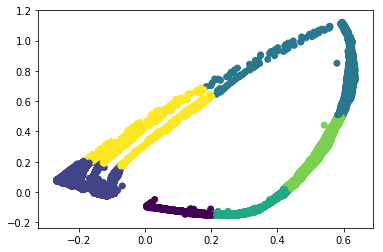

Comparing k-means clusters against the data:
overall  1      2      3      4      5      6      7      8      9      10     \
row_0                                                                           
0            0      0      0      0      0      0      0      0      0      0   
1            0      0      0      0      0      0      0      0      0      0   
2            2      2      2      2      2      2      2      2      2      2   
3            0      0      0      0      0      0      0      0      0      0   
4            0      0      0      0      0      0      0      0      0      0   
5            0      0      0      0      0      0      0      0      0      0   

overall  11     12     13     14     15     16     17     18     19     20     \
row_0                                                                           
0            0      0      0      0      0      0      0      0      0      0   
1            0      0      0      0      0      0      0      0

In [39]:
# DO NOT DO THIS UNTIL READY TO GRAPH 
# Reduce it to two components.
X_pca = PCA(2).fit_transform(X_norm)

# Calculate predicted values.
y_pca_pred = Kmean.fit_predict(X_pca)

# Plot the solution.
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred)
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))

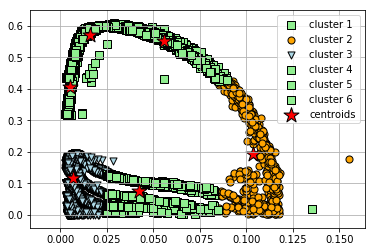

In [42]:
# plot the 6 clusters
plt.scatter(
    X_norm[y_pred == 0, 0], X_norm[y_pred == 0, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    X_norm[y_pred == 1, 0], X_norm[y_pred == 1, 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)

plt.scatter(
    X_norm[y_pred == 2, 0], X_norm[y_pred == 2, 1],
    s=50, c='lightblue',
    marker='v', edgecolor='black',
    label='cluster 3'
)

plt.scatter(
    X_norm[y_pred == 3, 0], X_norm[y_pred == 3, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 4'
)

plt.scatter(
    X_norm[y_pred == 4, 0], X_norm[y_pred == 4, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 5'
)

plt.scatter(
    X_norm[y_pred == 5, 0], X_norm[y_pred == 5, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 6'
)

# plot the centroids
plt.scatter(
    Kmean.cluster_centers_[:, 0], Kmean.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

In [44]:
# Each batch will be made up of 200 data points.
minibatchkmeans = MiniBatchKMeans(
    init='random',
    n_clusters=6,
    batch_size=200,
    random_state=42)
minibatchkmeans.fit(X_norm)

# Predict new MiniBatch cluster memberships.
pred_y_mini = minibatchkmeans.predict(X_norm)

# Check the MiniBatch model against our earlier one.
print('Comparing k-means and mini batch k-means solutions:')
print(pd.crosstab(pred_y_mini, y_pred))

Comparing k-means and mini batch k-means solutions:
col_0     0    1      2     3    4    5
row_0                                  
0      2327    0      0     0    0    0
1         0    0   6164     0    0  578
2         0    0  12080     0    0    6
3         0    0      0  4117  532    0
4      4310    0      0   754    0    0
5         0  540      0     0  463  113


In [46]:
#finding the centroid
minibatchkmeans.cluster_centers_

array([[4.00988468e-03, 3.31559695e-01, 1.09765334e-02, 2.22882337e-03,
        1.97570932e-02, 9.42461029e-01, 1.58536796e-02, 7.54142021e-04,
        1.32016195e-02, 2.01847072e-03, 8.70466860e-03, 8.22918784e-03,
        1.86188778e-02, 1.21367092e-03, 7.16506947e-05, 0.00000000e+00,
        0.00000000e+00, 8.13218375e-07, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        4.94295923e-07, 0.00000000e+00, 6.89795383e-05, 1.36364213e-06],
       [9.63372541e-03, 4.79156386e-02, 2.48100941e-02, 1.05071025e-02,
        4.33915903e-02, 9.91019854e-01, 3.53909702e-02, 1.65640030e-03,
        2.98433847e-02, 4.80644849e-03, 2.05603950e-02, 1.94837835e-02,
        4.10106783e-02, 2.66571126e-03, 9.70982609e-05, 8.14628615e-07,
        0.00000000e+00, 2.27458122e-05, 0.00000000e+00, 4.18551

In [47]:
# plot the 6 clusters
plt.scatter(
    X_norm[pred_y_mini == 0, 0.], X_norm[pred_y_mini == 0, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    X_norm[pred_y_mini == 1, 0], X_norm[pred_y_mini == 1, 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)

plt.scatter(
    X_norm[pred_y_mini == 2, 0], X_norm[pred_y_mini == 2, 1],
    s=50, c='lightblue',
    marker='v', edgecolor='black',
    label='cluster 3'
)

plt.scatter(
    X_norm[pred_y_mini == 3, 0], X_norm[pred_y_mini == 3, 1],
    s=50, c='lightblue',
    marker='v', edgecolor='black',
    label='cluster 4'
)

plt.scatter(
    X_norm[pred_y_mini == 4, 0], X_norm[pred_y_mini == 4, 1],
    s=50, c='lightblue',
    marker='v', edgecolor='black',
    label='cluster 5'
)

plt.scatter(
    X_norm[pred_y_mini == 5, 0], X_norm[pred_y_mini == 5, 1],
    s=50, c='lightblue',
    marker='v', edgecolor='black',
    label='cluster 6'
)

# plot the centroids
plt.scatter(
    minibatchkmeans.cluster_centers_[:, 0], minibatchkmeans.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

## other clusters

In [48]:
from sklearn.model_selection import train_test_split

#divide data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X_norm,
    y,
    test_size=0.9,
    random_state=42)

In [49]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_train, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))


Number of estimated clusters: 6


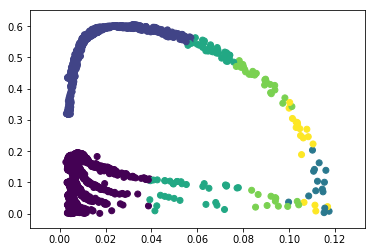

Comparing the assigned categories to the ones in the data:
col_0    0  1  2  3  4  5
overall                  
2        0  0  1  0  0  0
19       0  0  1  0  0  0
20       0  0  1  0  0  0
33       0  0  1  0  0  0
38       0  0  1  0  0  0
48       0  0  1  0  0  0
57       0  0  1  0  0  0
65       0  0  1  0  0  0
80       0  0  1  0  0  0
97       0  0  0  0  0  1
106      0  0  0  0  0  1
109      0  0  0  0  0  1
121      0  0  1  0  0  0
151      0  0  0  0  0  1
161      0  0  0  0  0  1
168      0  0  0  0  1  0
177      0  0  0  0  1  0
183      0  0  0  0  1  0
189      0  0  0  0  1  0
190      0  0  0  0  1  0
201      0  0  0  0  1  0
205      0  0  0  0  1  0
207      0  0  0  0  1  0
215      0  0  0  0  1  0
216      0  0  0  0  1  0
222      0  0  1  0  0  0
224      0  0  0  0  1  0
236      0  0  0  0  1  0
242      0  0  0  0  1  0
251      0  0  0  0  1  0
...     .. .. .. .. .. ..
31671    0  1  0  0  0  0
31673    0  1  0  0  0  0
31680    0  1  0  0  0  0
31699

In [50]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=labels)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train,labels))

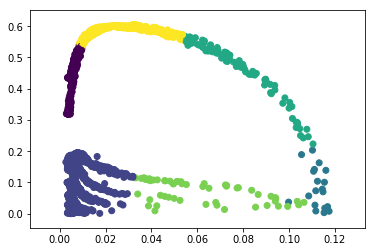

Comparing the assigned categories to the ones in the data:
col_0    0  1  2  3  4  5
overall                  
2        0  0  1  0  0  0
19       0  0  1  0  0  0
20       0  0  1  0  0  0
33       0  0  1  0  0  0
38       0  0  1  0  0  0
48       0  0  1  0  0  0
57       0  0  1  0  0  0
65       0  0  1  0  0  0
80       0  0  1  0  0  0
97       0  0  0  1  0  0
106      0  0  0  1  0  0
109      0  0  0  1  0  0
121      0  0  1  0  0  0
151      0  0  0  1  0  0
161      0  0  0  1  0  0
168      0  0  0  1  0  0
177      0  0  0  1  0  0
183      0  0  0  0  1  0
189      0  0  0  1  0  0
190      0  0  0  0  1  0
201      0  0  0  0  1  0
205      0  0  0  1  0  0
207      0  0  0  1  0  0
215      0  0  0  1  0  0
216      0  0  0  1  0  0
222      0  0  1  0  0  0
224      0  0  0  1  0  0
236      0  0  0  1  0  0
242      0  0  0  1  0  0
251      0  0  0  1  0  0
...     .. .. .. .. .. ..
31671    1  0  0  0  0  0
31673    1  0  0  0  0  0
31680    1  0  0  0  0  0
31699

In [51]:
from sklearn.cluster import SpectralClustering

# looking for 6 clusters.
n_clusters=6

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters)
sc.fit(X_train)

#Predicted clusters.
predict=sc.fit_predict(X_train)

#Graph results.
plt.scatter(X_train[:, 0], X_train[:, 1], c=predict)
plt.show()

print('Comparing the assigned categories to the ones in the data:')
print(pd.crosstab(y_train,predict))

In [53]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

# Declare the model and fit 
af = AffinityPropagation().fit(X_train)
print('Done')

# Pull the number of clusters and cluster assignments for each data point.
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

print('Estimated number of clusters: {}'.format(n_clusters_))

Done
Estimated number of clusters: 1129


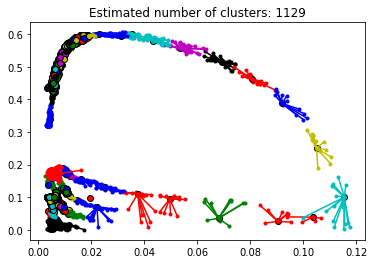

In [54]:
from itertools import cycle

plt.figure(1)
plt.clf()

# Cycle through each cluster and graph them with a center point for the
# exemplar and lines from the exemplar to each data point in the cluster.
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X_train[cluster_centers_indices[k]]
    plt.plot(X_train[class_members, 0], X_train[class_members, 1], col + '.')
    plt.plot(cluster_center[0],
             cluster_center[1],
             'o',
             markerfacecolor=col,
             markeredgecolor='k')
    for x in X_train[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: {}'.format(n_clusters_))
plt.show()

## evaluation

In [59]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA


# Make sure the number of rows divides evenly into four samples.
rows = df_boston.shape[0] - df_boston.shape[0] % 4
df_eval = df_boston.iloc[:rows, :]

# Break into a set of features and a variable for the known outcome.
X = df_eval.loc[:, df_eval.columns != 'overall']
y = df_eval['overall']

# Normalize
X_norm = normalize(X)

# Data frame to store features and predicted cluster memberships.
ypred = pd.DataFrame()

# Create the two-feature PCA for graphing purposes.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)

# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_norm,
    X_pca,
    test_size=0.5,
    random_state=42)

# Then we halve the halves.
X1, X2, X_pca1, X_pca2 = train_test_split(
    X_half1,
    X_pcahalf1,
    test_size=0.5,
    random_state=42)
X3, X4, X_pca3, X_pca4 = train_test_split(
    X_half2,
    X_pcahalf2,
    test_size=0.5,
    random_state=42)

# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by k-means,
# and the PCA-derived features for graphing. We use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# PCA solution in the data frame.
for counter, data in enumerate([
    (X1, X_pca1),
    (X2, X_pca2),
    (X3, X_pca3),
    (X4, X_pca4)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2, 7):
        pred = KMeans(n_clusters=nclust, random_state=42).fit_predict(data[0])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

KeyError: 'pca_f1_sample4'

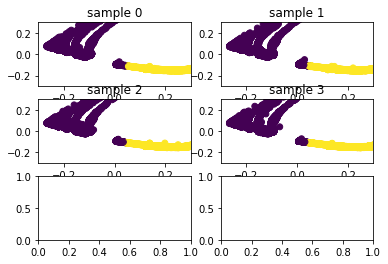

In [60]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 7):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(3, 2)
    
    # Make a plot for each sample.
    for i in range(5):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        rows = int(np.floor(i / 2))
        cols = i % 2
        axarr[rows, cols].scatter(x_sub, y_sub, c=c)
        axarr[rows, cols].set_title('sample {}'.format(i))
        axarr[rows, cols].set_xlim([-.3, .3])
        axarr[rows, cols].set_ylim([-.3, .3])
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

In [61]:
# Get predicted clusters.
full_pred = KMeans(n_clusters=6, random_state=42).fit_predict(X_norm)

pd.crosstab(y, full_pred) 

col_0,0,1,2,3,4,5
overall,,,,,,
1,0,2,0,0,0,0
2,0,2,0,0,0,0
3,0,2,0,0,0,0
4,0,2,0,0,0,0
5,0,2,0,0,0,0
6,0,2,0,0,0,0
7,0,2,0,0,0,0
8,0,2,0,0,0,0
9,0,2,0,0,0,0



import itertools

# Create a list of pairs, where each pair is the ground truth group
# and the assigned cluster.
c = list(itertools.product(y, full_pred))

# Count how often each type of pair (a, b, c, or d) appears.
RIcounts = [[x, c.count(x)] for x in set(c)]
print(RIcounts)

# Create the same counts but without the label, for easier math below.
RIcounts_nolabel = [c.count(x) for x in set(c)]

# Calculate the Rand Index.
RIscore = (RIcounts_nolabel[3] + RIcounts_nolabel[2]) / np.sum(RIcounts_nolabel)
print(RIscore)

In [63]:
from sklearn import metrics
    
metrics.adjusted_rand_score(y, full_pred)

3.196524358689651e-07

In [64]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances

for sample in [X1, X2, X3, X4]:
    model = KMeans(n_clusters=2, random_state=42).fit(sample)
    labels = model.labels_
    print(metrics.silhouette_score(sample, labels, metric='euclidean'))

0.6430482558072835
0.6385447099640904
0.6374533645851282
0.6425372865797574
